In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Device: cuda
[REAL-train] found 139 videos.


Indexing REAL-train: 100%|██████████| 139/139 [01:39<00:00,  1.40it/s]


REAL-train -> total samples(frames): 1595088
[REAL-val] found 13 videos.


Indexing REAL-val: 100%|██████████| 13/13 [00:42<00:00,  3.30s/it]


REAL-val -> total samples(frames): 185756
[REAL-test] found 17 videos.


Indexing REAL-test: 100%|██████████| 17/17 [00:50<00:00,  2.97s/it]


REAL-test -> total samples(frames): 194572
REAL Train: 1595088 | Val: 185756 | Test: 194572
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 215MB/s]


Partial load from last.pt done.
Missing keys: 267 | Unexpected keys: 363


Epoch 01 | Train Loss: 0.114132 | Val Loss: 0.029504 | Val Angular(REAL): 9.54° | LR=(1.67e-06, 6.67e-06)
✅ Best REAL-only model saved: /content/drive/MyDrive/dataset_split/best_gaze_finetuned_REAL_ONLY_from_last.pt


Epoch 02 | Train Loss: 0.031005 | Val Loss: 0.019129 | Val Angular(REAL): 6.83° | LR=(3.33e-06, 1.33e-05)
✅ Best REAL-only model saved: /content/drive/MyDrive/dataset_split/best_gaze_finetuned_REAL_ONLY_from_last.pt


Epoch 03 | Train Loss: 0.022001 | Val Loss: 0.009928 | Val Angular(REAL): 5.53° | LR=(5.00e-06, 2.00e-05)
✅ Best REAL-only model saved: /content/drive/MyDrive/dataset_split/best_gaze_finetuned_REAL_ONLY_from_last.pt


Epoch 04 | Train Loss: 0.011819 | Val Loss: 0.006093 | Val Angular(REAL): 4.15° | LR=(5.00e-06, 2.00e-05)
✅ Best REAL-only model saved: /content/drive/MyDrive/dataset_split/best_gaze_finetuned_REAL_ONLY_from_last.pt


Epoch 05 | Train Loss: 0.009090 | Val Loss: 0.005635 | Val Angular(REAL): 3.72° | LR=(5.00e-06, 2.00e-05)
✅ Best REAL-only model saved: /content/drive/MyDrive/dataset_split/best_gaze_finetuned_REAL_ONLY_from_last.pt


Epoch 06 | Train Loss: 0.008649 | Val Loss: 0.005958 | Val Angular(REAL): 3.40° | LR=(5.00e-06, 2.00e-05)


Epoch 07 | Train Loss: 0.007920 | Val Loss: 0.004608 | Val Angular(REAL): 3.15° | LR=(5.00e-06, 2.00e-05)
✅ Best REAL-only model saved: /content/drive/MyDrive/dataset_split/best_gaze_finetuned_REAL_ONLY_from_last.pt


Epoch 08 | Train Loss: 0.005125 | Val Loss: 0.003277 | Val Angular(REAL): 2.97° | LR=(5.00e-06, 2.00e-05)
✅ Best REAL-only model saved: /content/drive/MyDrive/dataset_split/best_gaze_finetuned_REAL_ONLY_from_last.pt


Epoch 09 | Train Loss: 0.006214 | Val Loss: 0.004754 | Val Angular(REAL): 2.77° | LR=(5.00e-06, 2.00e-05)


Epoch 10 | Train Loss: 0.006319 | Val Loss: 0.003530 | Val Angular(REAL): 2.83° | LR=(5.00e-06, 2.00e-05)


Epoch 11 | Train Loss: 0.005576 | Val Loss: 0.005239 | Val Angular(REAL): 2.96° | LR=(5.00e-06, 2.00e-05)


Epoch 12 | Train Loss: 0.005647 | Val Loss: 0.003482 | Val Angular(REAL): 2.82° | LR=(2.50e-06, 1.00e-05)


Epoch 13 | Train Loss: 0.004094 | Val Loss: 0.002960 | Val Angular(REAL): 2.29° | LR=(2.50e-06, 1.00e-05)
✅ Best REAL-only model saved: /content/drive/MyDrive/dataset_split/best_gaze_finetuned_REAL_ONLY_from_last.pt


Epoch 14 | Train Loss: 0.004162 | Val Loss: 0.003452 | Val Angular(REAL): 2.40° | LR=(2.50e-06, 1.00e-05)


Epoch 15 | Train Loss: 0.008862 | Val Loss: 0.002426 | Val Angular(REAL): 2.22° | LR=(2.50e-06, 1.00e-05)
✅ Best REAL-only model saved: /content/drive/MyDrive/dataset_split/best_gaze_finetuned_REAL_ONLY_from_last.pt
Best REAL-only val loss: 0.002425850519503001


REAL Test: 100%|██████████| 24322/24322 [26:16<00:00, 15.43it/s]


✅ REAL-ONLY TEST Angular Error: 2.70°


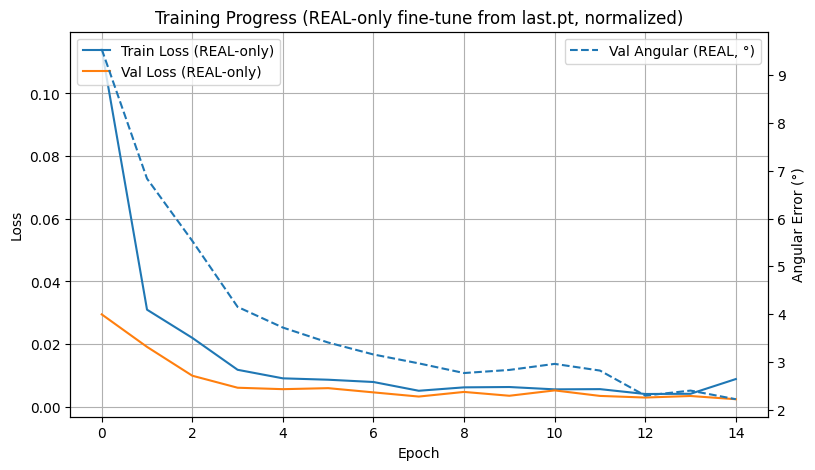

In [ ]:
# ============================================================
# REAL-ONLY FINE-TUNE from last.pt (REAL pretrained model)
#   - Veri: Sadece TEyeD (real) -> train/val/test
#   - Model: ResNet50, çıkış: 3D gaze vector (gx, gy, gz)
#   - Başlangıç: last.pt (REAL üzerinde eğitilmiş)
#   - Hiç sentetik yok, mixing yok.
#   - Loss: normalized vektörler üzerinde
#           alpha * (1 - cos) + (1 - alpha) * MSE
# ============================================================

import os, math, random, numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T, models

# ------------------ ENV ------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

torch.manual_seed(42)
if device == "cuda":
    torch.cuda.manual_seed_all(42)
np.random.seed(42)
random.seed(42)
EPS = 1e-8

# ------------------ PATHS ------------------
REAL_ROOT = "/content/drive/MyDrive/dataset_split/real_gaze_vectors_videos_and_texts_split"
CKPT_PATH = "/content/drive/MyDrive/dataset_split/last.pt"   # REAL pretrained
SAVE_BEST = "/content/drive/MyDrive/dataset_split/best_gaze_finetuned_REAL_ONLY_from_last.pt"

# ============================================================
# 1) Loss & metric (NORMALIZE EDİLMİŞ VEKTÖRLER ÜZERİNDE)
# ============================================================

def combined_loss(pred, tgt, alpha=0.8):
    """
    alpha * (1 - cos) + (1 - alpha) * MSE,
    -> HEM pred HEM tgt normalize edilerek.
    REAL-only aşamada cosine'i biraz daha ağır bastırıyoruz (alpha=0.8).
    """
    pred_n = F.normalize(pred, dim=1)
    tgt_n  = F.normalize(tgt,  dim=1)

    cos = torch.sum(pred_n * tgt_n, dim=1).clamp(-1.0, 1.0)
    cos_loss = (1.0 - cos).mean()
    mse_loss = F.mse_loss(pred_n, tgt_n)

    return alpha * cos_loss + (1.0 - alpha) * mse_loss

def angular_error_deg(pred, gt):
    pred = F.normalize(pred, dim=1)
    gt   = F.normalize(gt,   dim=1)
    cos_sim = torch.clamp(torch.sum(pred * gt, dim=1), -1.0, 1.0)
    return torch.rad2deg(torch.acos(cos_sim))

# ============================================================
# 2) REAL TEyeD Dataset
# ============================================================

class TEyeDRealDataset(Dataset):
    """
    REAL TEyeD:
      REAL_ROOT/split/*.mp4
      REAL_ROOT/split/*.mp4gaze_vec.txt

    TXT formatı:
      FRAME;X;Y;Z;
      1;-0.0218;-0.0039;0.9997;
      ...
    """
    def __init__(self, root_dir, split="train", transform=None):
        self.root_dir = os.path.join(root_dir, split)
        self.transform = transform
        self.samples = []  # (video_path, frame_idx, gaze)

        if not os.path.exists(self.root_dir):
            print(f"UYARI: REAL dizini yok: {self.root_dir}")
            return

        video_files = sorted([f for f in os.listdir(self.root_dir) if f.lower().endswith(".mp4")])
        print(f"[REAL-{split}] found {len(video_files)} videos.")

        for vname in tqdm(video_files, desc=f"Indexing REAL-{split}"):
            vpath = os.path.join(self.root_dir, vname)
            txt_name = vname + "gaze_vec.txt"
            tpath = os.path.join(self.root_dir, txt_name)
            if not os.path.exists(tpath):
                print(f"[WARN] Gaze file yok: {txt_name}")
                continue

            frame_ids, gazes = self._load_gaze_file(tpath)

            cap = cv2.VideoCapture(vpath)
            if not cap.isOpened():
                print(f"[WARN] Video acilamadi: {vpath}")
                continue
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            cap.release()

            L = min(total_frames, len(frame_ids))
            for i in range(L):
                self.samples.append((vpath, int(frame_ids[i]), gazes[i]))

        print(f"REAL-{split} -> total samples(frames): {len(self.samples)}")

    def _load_gaze_file(self, txt_path):
        frame_ids = []
        gazes = []
        with open(txt_path, "r") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                parts = line.split(";")
                if parts[0].upper() == "FRAME":
                    continue
                if len(parts) < 4:
                    continue
                try:
                    frame_id = int(float(parts[0]))
                    gx = float(parts[1]); gy = float(parts[2]); gz = float(parts[3])
                except ValueError:
                    continue
                frame_ids.append(max(0, frame_id - 1))  # 1-based -> 0-based
                gazes.append([gx, gy, gz])

        if len(frame_ids) == 0:
            raise RuntimeError(f"No valid gaze entries in {txt_path}")
        frame_ids = np.array(frame_ids, dtype=np.int64)
        gazes = np.array(gazes, dtype=np.float32)
        return frame_ids, gazes

    def __len__(self):
        return len(self.samples)

    def _read_frame(self, video_path, frame_idx):
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise RuntimeError(f"Could not open {video_path}")
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ok, frame = cap.read()
        cap.release()
        if not ok:
            raise RuntimeError(f"Could not read frame {frame_idx} from {video_path}")
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        return frame

    def __getitem__(self, idx):
        vpath, fidx, gaze = self.samples[idx]
        img = self._read_frame(vpath, fidx)
        if self.transform:
            img = self.transform(img)
        tgt = torch.tensor(gaze, dtype=torch.float32)  # normalize'i loss/metric içinde yapıyoruz
        return img, tgt

# ============================================================
# 3) Transforms (ImageNet normalize ile)
# ============================================================

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

real_tf_train = T.Compose([
    T.ToPILImage(),
    T.Resize((224, 224)),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

real_tf_eval = T.Compose([
    T.ToPILImage(),
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# ============================================================
# 4) Datasets & DataLoaders
# ============================================================

train_dataset = TEyeDRealDataset(REAL_ROOT, 'train', real_tf_train)
val_dataset   = TEyeDRealDataset(REAL_ROOT, 'val',   real_tf_eval)
test_dataset  = TEyeDRealDataset(REAL_ROOT, 'test',  real_tf_eval)

BATCH_SIZE = 8
NUM_WORKERS = 4 if device=="cuda" else 2

def make_loader(ds, shuffle):
    return DataLoader(
        ds, batch_size=BATCH_SIZE, shuffle=shuffle,
        num_workers=NUM_WORKERS, pin_memory=(device=="cuda"),
        persistent_workers=(device=="cuda" and NUM_WORKERS>0 and len(ds)>0),
        prefetch_factor=4 if device=="cuda" else 2
    )

train_loader = make_loader(train_dataset, True)
val_loader   = make_loader(val_dataset,   False)
test_loader  = make_loader(test_dataset,  False)

print(f"REAL Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

# ============================================================
# 5) Model: ResNet50 -> 3D gaze vector
# ============================================================

gaze_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
gaze_model.fc = nn.Linear(gaze_model.fc.in_features, 3)
gaze_model = gaze_model.to(device)

# last.pt REAL pretrained yükle
try:
    ckpt = torch.load(CKPT_PATH, map_location="cpu", weights_only=False)
    sd = ckpt.get("state_dict", ckpt)
    rep = gaze_model.load_state_dict(sd, strict=False)
    print("Partial load from last.pt done.")
    print(f"Missing keys: {len(rep.missing_keys)} | Unexpected keys: {len(rep.unexpected_keys)}")
except Exception as e:
    print(f"Checkpoint load skipped: {e}")

# ============================================================
# 6) Optimizer (REAL-only, düşük LR) + Scheduler + Warmup
# ============================================================

head_params = list(gaze_model.fc.parameters())
backbone_params = [p for n,p in gaze_model.named_parameters() if not n.startswith('fc.')]

optimizer = torch.optim.AdamW(
    [{'params': backbone_params, 'lr': 5e-6},
     {'params': head_params,     'lr': 2e-5}],
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

WARMUP_EPOCHS = 3
BASE_LR_BB, BASE_LR_HD = 5e-6, 2e-5

def apply_warmup(opt, epoch):
    if epoch <= WARMUP_EPOCHS:
        k = epoch / float(WARMUP_EPOCHS)
        opt.param_groups[0]['lr'] = BASE_LR_BB * k
        opt.param_groups[1]['lr'] = BASE_LR_HD * k

# ============================================================
# 7) Train loop (REAL ONLY, normalized loss)
# ============================================================

EPOCHS = 15
MAX_REAL_BATCHES_PER_EPOCH = 500   # her epoch ~500 batch (isteğe göre)
MAX_VAL_BATCHES = 100

best_val = float("inf")
train_losses, val_losses, val_angles = [], [], []

for epoch in range(1, EPOCHS+1):
    gaze_model.train()
    apply_warmup(optimizer, epoch)

    tr_loss = 0.0
    used_batches = 0

    for batch_idx, (xr, tr) in enumerate(
        tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [Train]", leave=False)
    ):
        if batch_idx >= MAX_REAL_BATCHES_PER_EPOCH:
            break

        xr, tr = xr.to(device), tr.to(device)
        optimizer.zero_grad(set_to_none=True)
        out = gaze_model(xr)
        loss = combined_loss(out, tr, alpha=0.8)  # normalized combined loss
        loss.backward()
        optimizer.step()

        tr_loss += loss.item()
        used_batches += 1

    tr_loss /= max(1, used_batches)

    # ---------- Validation ----------
    gaze_model.eval()
    va_loss, va_ang_list = 0.0, []
    with torch.no_grad():
        for batch_idx, (xr, tr) in enumerate(
            tqdm(val_loader, desc=f"Epoch {epoch}/{EPOCHS} [Val]", leave=False)
        ):
            if batch_idx >= MAX_VAL_BATCHES:
                break
            xr, tr = xr.to(device), tr.to(device)
            out = gaze_model(xr)
            loss = combined_loss(out, tr, alpha=0.8)
            va_loss += loss.item()
            va_ang_list.append(angular_error_deg(out, tr).mean().item())

    va_loss /= max(1, min(MAX_VAL_BATCHES, len(val_loader)))
    va_ang = float(np.mean(va_ang_list)) if len(va_ang_list) else float('inf')

    train_losses.append(tr_loss)
    val_losses.append(va_loss)
    val_angles.append(va_ang)

    print(f"Epoch {epoch:02d} | Train Loss: {tr_loss:.6f} | Val Loss: {va_loss:.6f} "
          f"| Val Angular(REAL): {va_ang:.2f}° "
          f"| LR=({optimizer.param_groups[0]['lr']:.2e}, {optimizer.param_groups[1]['lr']:.2e})")

    scheduler.step(va_loss)

    if va_loss + 1e-12 < best_val:
        best_val = va_loss
        torch.save(gaze_model.state_dict(), SAVE_BEST)
        print("✅ Best REAL-only model saved:", SAVE_BEST)

print("Best REAL-only val loss:", best_val)

# ============================================================
# 8) Test (REAL)
# ============================================================

gaze_model.load_state_dict(torch.load(SAVE_BEST, map_location=device))
gaze_model.to(device)
gaze_model.eval()

test_angles_real = []
with torch.no_grad():
    for xr, tr in tqdm(test_loader, desc="REAL Test"):
        xr, tr = xr.to(device), tr.to(device)
        ang = angular_error_deg(gaze_model(xr), tr)
        test_angles_real.append(ang.mean().item())
print(f"✅ REAL-ONLY TEST Angular Error: {np.mean(test_angles_real):.2f}°")

# ============================================================
# 9) Plot'lar (opsiyonel)
# ============================================================

fig, ax1 = plt.subplots(figsize=(9,5))
ax1.plot(train_losses, label="Train Loss (REAL-only)")
ax1.plot(val_losses,   label="Val Loss (REAL-only)")
ax1.set_xlabel("Epoch"); ax1.set_ylabel("Loss"); ax1.grid(True); ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(val_angles, label="Val Angular (REAL, °)", linestyle='--')
ax2.set_ylabel("Angular Error (°)")
ax2.legend(loc='upper right')

plt.title("Training Progress (REAL-only fine-tune from last.pt, normalized)")
plt.show()
